In [1]:
%load_ext autoreload
%autoreload 2

import torch
#from rl4co.envs import DARPEnv 
from rl4co.envs.routing import PDPTWGenerator, CVRPTWGenerator, SFGenerator
from rl4co.envs.routing import PDPTWEnv, CVRPTWEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.models.zoo.pomo.model import POMO
from rl4co.utils.trainer import RL4COTrainer
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary
from rl4co.models.zoo import AttentionModel


In [2]:
instance = SFGenerator()._generate(batch_size=[1])
instance["h3_indices"]

tensor([[ 69,  46,  82,  14, 101, 180,  43, 170,  46, 170, 129,  46, 129, 127,
          71,  82,  50, 187,   8,  46,  35,  78, 114, 191, 129,  50, 127,  46,
          76, 147, 196,  46, 146,  14, 158,  14,  54, 127,  82,  46, 168,  46,
          68, 127, 189,  46,  64,  46,   7,  50,  46, 170,  78,  82, 111,  46,
          50,  46,  91,  14, 161]])

In [3]:
env = PDPTWEnv()
td = env.reset(batch_size=[1]) 
td

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.bool, is_shared=False),
        capacity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        current_node: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_time: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        demand: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        h3_indices: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([1, 61, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        pending_count: Tensor(shape=torch.Size([1, 1]), device=cpu, d

In [4]:
# RL4CO env based on TorchRL
env = PDPTWEnv()

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(
    env,
    policy=policy,            # or omit to use the default AttentionModelPolicy
    baseline="rollout",
    batch_size=512,
    train_data_size=100_000,
    val_data_size=10_000,
    optimizer_kwargs={"lr": 1e-4},
    metrics={
        "train": ["loss", "reward", "vehicles_used", "waiting_penalty"],
        "val": ["reward", "vehicles_used", "waiting_penalty"],
        "test": ["reward", "vehicles_used", "waiting_penalty"],
    },
)

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[1]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

out

{'reward': tensor([-1006.7500]),
 'log_likelihood': tensor([-57.1021], grad_fn=<SumBackward1>),
 'actions': tensor([[51, 31, 59, 39, 52, 19, 20,  0, 47, 29, 13, 17, 48, 27, 28,  0, 30, 53,
          54,  0,  1, 23, 24, 35, 36,  0, 25,  9, 26, 21,  5, 22,  6,  0, 57, 58,
          11, 12,  0, 33, 34, 15, 16, 10,  7,  8, 43, 44,  0,  3, 49,  4, 50, 55,
          56, 41, 37, 38, 42,  0, 18,  2, 45, 46,  0, 32, 40, 14,  0, 60,  0]])}

In [7]:
out['actions']


tensor([[51, 31, 59, 39, 52, 19, 20,  0, 47, 29, 13, 17, 48, 27, 28,  0, 30, 53,
         54,  0,  1, 23, 24, 35, 36,  0, 25,  9, 26, 21,  5, 22,  6,  0, 57, 58,
         11, 12,  0, 33, 34, 15, 16, 10,  7,  8, 43, 44,  0,  3, 49,  4, 50, 55,
         56, 41, 37, 38, 42,  0, 18,  2, 45, 46,  0, 32, 40, 14,  0, 60,  0]])

In [8]:
node = 59
print(td_init["locs"][0][node])
print(td_init["time_windows"][0][node])

tensor([  37.7516, -122.4325])
tensor([450., 480.])


In [9]:
td = env.reset(batch_size=[1]).to(device)
td

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.bool, is_shared=False),
        capacity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        current_node: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_time: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        demand: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        h3_indices: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([1, 61, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        pending_count: Tensor(shape=torch.Size([1, 1]), device=cpu, d

Problem 1 | Cost: 1000.083
{'reward': tensor([-1000.0834, -1012.0334, -1034.7500, -1091.7334, -1065.3500, -1010.9667,
        -1009.1833, -1002.0333,  -940.9000,  -935.6000, -1053.3500,  -891.0334,
        -1164.0166, -1027.9667,  -957.3500, -1001.6500, -1042.8667,  -921.9500,
         -977.9667,  -896.6833, -1049.1334,  -964.8167, -1000.7500,  -986.6334,
        -1178.1833, -1006.0500,  -958.7333, -1111.4000,  -965.2167,  -916.3667]), 'log_likelihood': tensor([-63.1999, -54.1887, -51.2599, -62.0497, -49.2243, -66.3536, -45.7055,
        -58.2593, -58.6364, -64.5153, -43.7683, -55.9306, -54.8765, -47.8803,
        -63.1157, -61.2849, -58.4092, -57.5986, -48.2364, -57.9869, -58.5660,
        -53.6174, -49.9733, -53.4337, -52.1154, -54.8456, -60.5247, -57.2728,
        -55.5391, -49.5554], grad_fn=<SumBackward1>), 'actions': tensor([[25, 26,  1,  ...,  0,  0,  0],
        [11, 45, 46,  ...,  0,  0,  0],
        [41,  3, 42,  ...,  0,  0,  0],
        ...,
        [25, 26,  9,  ...,  0,  

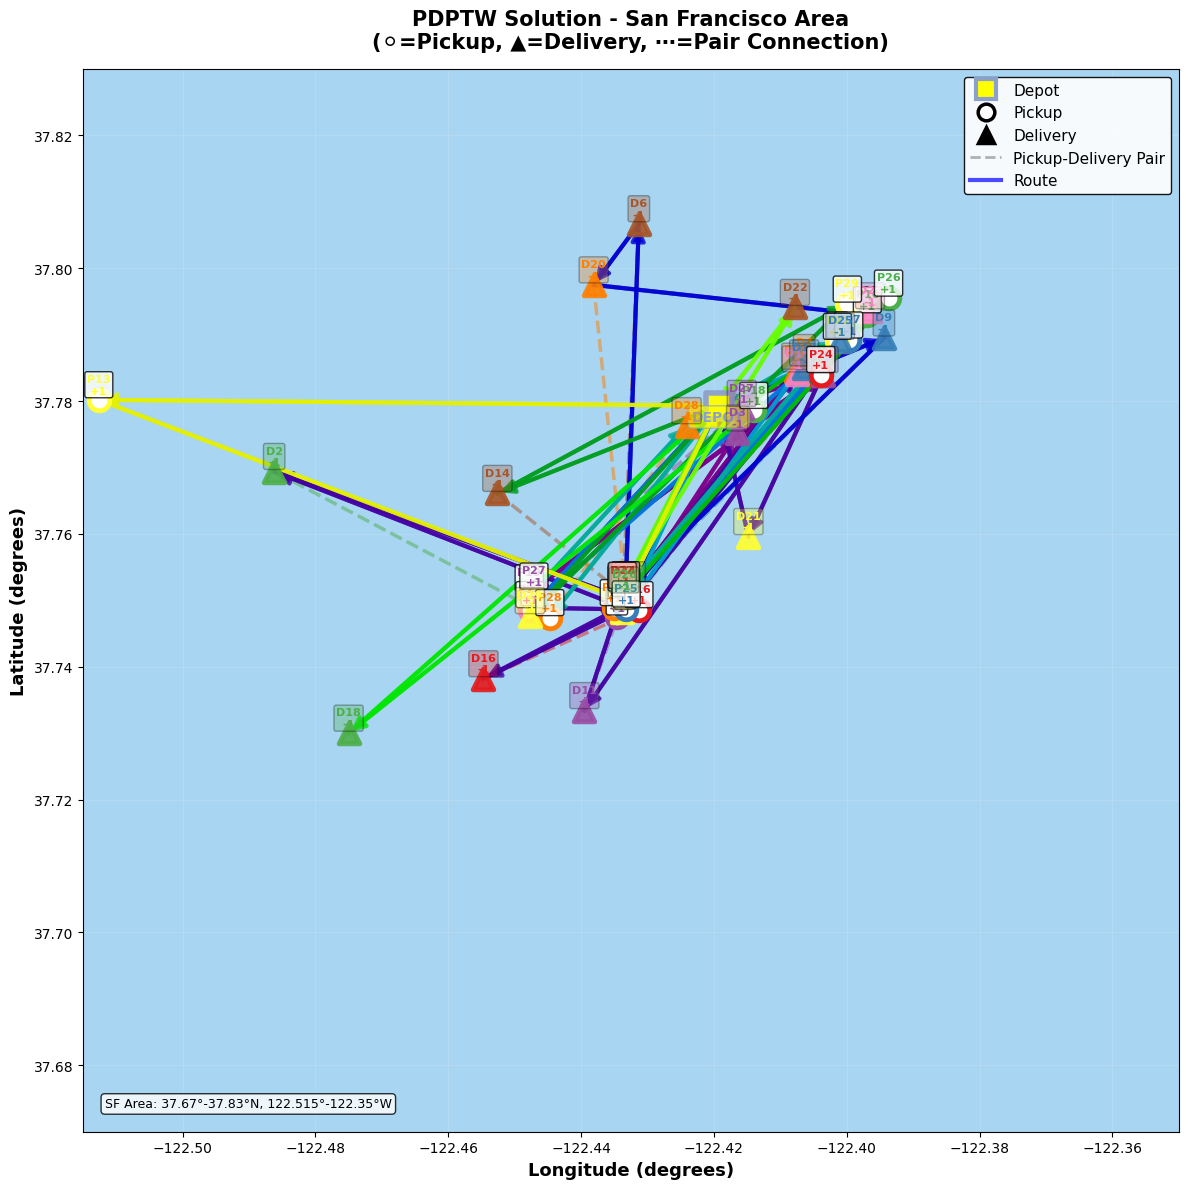

In [10]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[30]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(1):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

print(out)

In [13]:
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary
from lightning.pytorch.loggers import WandbLogger

import wandb
wandb.login()


logger = WandbLogger(project="rl4co", name="sf-run-2")


checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints/sf_run_2", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the

In [16]:
trainer = RL4COTrainer(
    max_epochs=50,
    accelerator="gpu",
    devices=-1,
    logger=logger,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ PDPTWEnv              │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  694 K │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  595 K │ train │
│ 3  │ policy.encoder.init_embedding          │ PDPTWInitEmbedding    │  1.2 K │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  594 K │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │ 98.7 K │ train │
│ 6  │ policy.decoder.context_embedding       │ PDPTWContext          │ 16.8 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ StaticEmbedding       │      0 │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ WarmupBaseline        │  694 K │ train │
│ 12 │ baseline.baseline                      │ RolloutBaseline       │  694 K │ train │
│ 13 │ baseline.baseline.policy               │ AttentionModelPolicy  │  694 K │ eval  │
│ 14 │ baseline.warmup_baseline               │ ExponentialBaseline   │      0 │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 73                                                                                          
Modules in eval mode: 69

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:527: Found 69 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is in

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[rank: 0] Received SIGTERM: 15

Detected KeyboardInterrupt, attempting graceful shutdown ...

KeyboardInterrupt



/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(
Web Mercator method failed: CRSError: The EPSG code is unknown. PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
Trying direct tile download method...
Web Mercator method failed: CRSError: The EPSG code is unknown. PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj

tensor([[ 7, 31, 49, 19,  8, 50, 32, 11, 20, 12,  3, 29,  4, 30, 53, 39, 37, 54,
         40, 38, 17, 15, 18, 43, 16, 44, 35, 13, 36, 14,  1, 57,  5, 58,  2, 41,
         59,  6, 42, 60, 25, 26,  0, 21, 22, 47, 48, 51, 55, 27, 23, 52, 24, 56,
         28,  9, 10, 45, 46, 33, 34]])


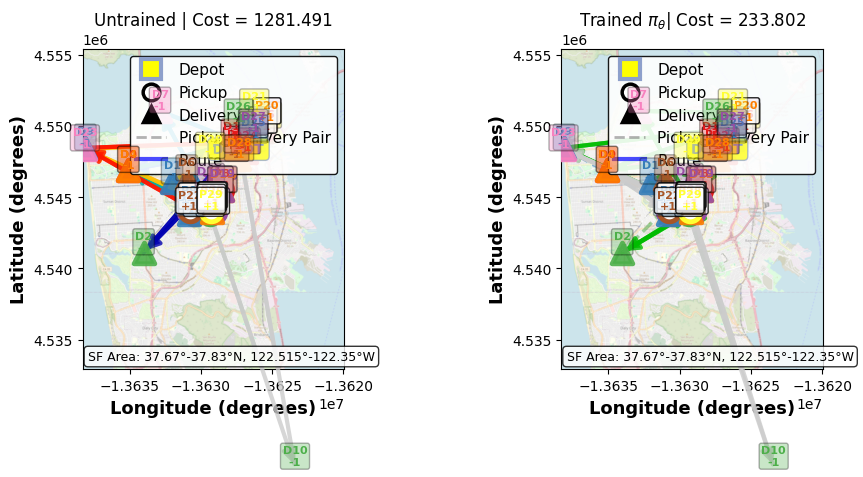

In [115]:
# Testing: Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

print(actions_trained)

In [117]:
td_init[0]["time_windows"] 
# Time window is in 30min interval; 
# First node 

tensor([[ 360., 1320.],
        [ 810.,  840.],
        [1290., 1320.],
        [ 750.,  780.],
        [1050., 1080.]])

In [119]:
actions_trained[0]

tensor([3, 1, 4, 2, 0])